<a href="https://colab.research.google.com/github/jerryadamsfranklin/Prediction-of-pre-eclampsia-in-pregnant-women/blob/main/DS5500_Project__SMOTE_ManaswiniNagaraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('gDrive')

Mounted at gDrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score

In [3]:
#read the dataset
protect = pd.read_csv("gDrive/MyDrive/Moi_kaggle/DS5500_dataset.csv", engine = "python")

In [4]:
#take a look at the dataset
protect.head()

,SYS_LOC_CODE,obdiffcard,obdiffhbp,obdiffkidney,obdiffliver,RACE__1,RACE__2,RACE__3,RACE__4,RACE__5,RACE__6,RACE__97,RACE__888,RACE__999,race97,hisp,smkever,alcdays,marijuse,druguse,fvcurrht_foot,fvcurrht_inch,wtprepreg,prembirthnum,pregnum,prevpreeclmp,preveclmp,currpreeclmp,curreclmp,currhd,currgd,prevhyp,preghyp_durante,prevdiab,pregdiab_durante,preglup_durante,prevlup,tvcurrpreeclmp,tvcurreclmp,tvcurrgd,ivf,MULTIFETUS,pptypelabor,ppinduct,pppretlabw,pppreeclampsia,vitd,vitdfreq,cal,calfreq
0,1001,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,NaN,1.0,0.0,1.0,0.0,0.0,5.0,1.0,85.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,1006,NaN,NaN,NaN,NaN,1,1,0,0,0,0,1,0,0,India,1.0,0.0,NaN,0.0,0.0,5.0,5.0,155.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,1009,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,NaN,1.0,1.0,1.0,0.0,0.0,5.0,3.0,200.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1012,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,NaN,1.0,1.0,1.0,0.0,0.0,5.0,2.0,152.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
4,1013,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,NaN,1.0,0.0,1.0,0.0,0.0,5.0,5.0,130.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN


Dataset Dimensions and Statistics

In [5]:
protect.shape

(1859, 50)

In [6]:
protect[1: ].isna().sum()

SYS_LOC_CODE           0
obdiffcard          1856
obdiffhbp           1856
obdiffkidney        1856
obdiffliver         1856
RACE__1                0
RACE__2                0
RACE__3                0
RACE__4                0
RACE__5                0
RACE__6                0
RACE__97               0
RACE__888              0
RACE__999              0
race97              1842
hisp                 128
smkever                3
alcdays             1060
marijuse               4
druguse               10
fvcurrht_foot         59
fvcurrht_inch         70
wtprepreg             12
prembirthnum         433
pregnum                6
prevpreeclmp         848
preveclmp            849
currpreeclmp          25
curreclmp             23
currhd                27
currgd                24
prevhyp              235
preghyp_durante      237
prevdiab             235
pregdiab_durante     236
preglup_durante      235
prevlup              233
tvcurrpreeclmp       153
tvcurreclmp          153
tvcurrgd             155


In [7]:
total = protect.isna().sum().sort_values(ascending=False)
percent = ((protect.isna().sum()/protect.isna().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
obdiffliver,1857,99.892415
obdiffcard,1857,99.892415
obdiffhbp,1857,99.892415
obdiffkidney,1857,99.892415
vitdfreq,1849,99.462076
race97,1843,99.139322
calfreq,1832,98.547606
pppretlabw,1823,98.063475
ppinduct,1777,95.589026
pppreeclampsia,1753,94.298010


Class distributions of the target variables

0.0    1830
1.0       1
Name: currpreeclmp, dtype: int64

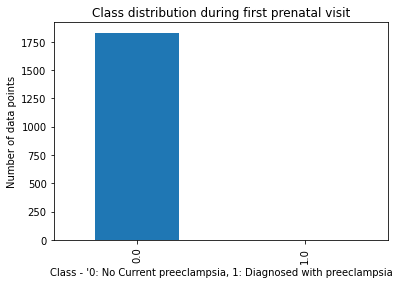

In [8]:
# Class distributions for the first prenatal visit
protect['currpreeclmp'].replace(888,np.NaN, inplace = True)
pd.value_counts(protect['currpreeclmp']).plot.bar()
plt.title("Class distribution during first prenatal visit")
plt.xlabel("Class - '0: No Current preeclampsia, 1: Diagnosed with preeclampsia")
plt.ylabel("Number of data points")
protect['currpreeclmp'].value_counts()


0.0    1701
1.0       2
Name: tvcurrpreeclmp, dtype: int64

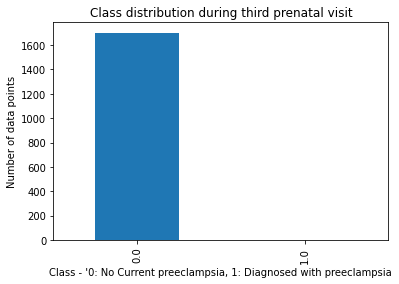

In [9]:
# Class distribtuions for the third prenatal visit
protect['tvcurrpreeclmp'].replace(888,np.NaN, inplace = True)
protect['tvcurrpreeclmp'].replace(999,np.NaN, inplace = True)
pd.value_counts(protect['tvcurrpreeclmp']).plot.bar()
plt.title("Class distribution during third prenatal visit")
plt.xlabel("Class - '0: No Current preeclampsia, 1: Diagnosed with preeclampsia")
plt.ylabel("Number of data points")
protect['tvcurrpreeclmp'].value_counts()

0.0    73
1.0    32
Name: pppreeclampsia, dtype: int64

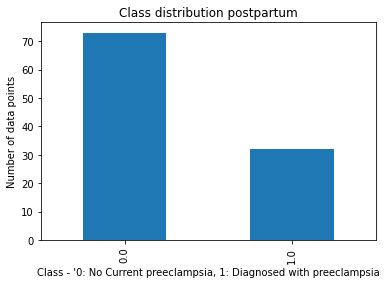

In [10]:
# Class distribution postpartum
protect['pppreeclampsia'].replace(9999,np.NaN, inplace = True)
pd.value_counts(protect['pppreeclampsia']).plot.bar()
plt.title("Class distribution postpartum")
plt.xlabel("Class - '0: No Current preeclampsia, 1: Diagnosed with preeclampsia")
plt.ylabel("Number of data points")
protect['pppreeclampsia'].value_counts()

Since the distribution across the three target variables are highly imbalanced and since only one maong the 3 variables have >5 minority class data points, we combine all 3 target variables to make a new variable called total_preeclampsia to get as many points for the minority class as possible.

In [11]:
#create new column for pre-eclampsia combining all pre-eclampsia data. Drop the rows that are null in the new column
#if currpreeclmp or tvcurrpreeclmp or pppreeclampsia == 1 then total_preeclampsia = 1 else if they are 0 then zero, if all are null, then null.
pd.to_numeric(protect['currpreeclmp'])
pd.to_numeric(protect['tvcurrpreeclmp'])
pd.to_numeric(protect['pppreeclampsia'])

#fill Nan values with 9999 for ease of imputation
protect.fillna(value = 9999, inplace= True)



In [12]:
conditions = [((protect['currpreeclmp'].astype(int, errors = 'ignore') == 1) | (protect['tvcurrpreeclmp'].astype(int, errors = 'ignore') == 1) | (protect['pppreeclampsia'].astype(int, errors = 'ignore') == 1)),
              ((protect['currpreeclmp'].astype(int, errors = 'ignore') == 0) | (protect['tvcurrpreeclmp'].astype(int, errors = 'ignore') == 0) | (protect['pppreeclampsia'].astype(int, errors = 'ignore') == 0)),
              ((protect['currpreeclmp']== 9999) | (protect['tvcurrpreeclmp'] == 9999) | (protect['pppreeclampsia'] == 9999))]
values = [1,0,9999]
protect["total_preeclampsia"] = np.select(conditions, values)
display(protect)


,SYS_LOC_CODE,obdiffcard,obdiffhbp,obdiffkidney,obdiffliver,RACE__1,RACE__2,RACE__3,RACE__4,RACE__5,RACE__6,RACE__97,RACE__888,RACE__999,race97,hisp,smkever,alcdays,marijuse,druguse,fvcurrht_foot,fvcurrht_inch,wtprepreg,prembirthnum,pregnum,prevpreeclmp,preveclmp,currpreeclmp,curreclmp,currhd,currgd,prevhyp,preghyp_durante,prevdiab,pregdiab_durante,preglup_durante,prevlup,tvcurrpreeclmp,tvcurreclmp,tvcurrgd,ivf,MULTIFETUS,pptypelabor,ppinduct,pppretlabw,pppreeclampsia,vitd,vitdfreq,cal,calfreq,total_preeclampsia
0,1001,9999.0,9999.0,9999.0,9999.0,1,0,0,0,0,0,0,0,0,9999,1.0,0.0,1.0,0.0,0.0,5.0,1.0,85.0,0.0,1.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
1,1006,9999.0,9999.0,9999.0,9999.0,1,1,0,0,0,0,1,0,0,India,1.0,0.0,9999.0,0.0,0.0,5.0,5.0,155.0,0.0,1.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
2,1009,9999.0,9999.0,9999.0,9999.0,0,0,1,0,0,0,0,0,0,9999,1.0,1.0,1.0,0.0,0.0,5.0,3.0,200.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0,1.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0
3,1012,9999.0,9999.0,9999.0,9999.0,1,0,0,0,0,0,0,0,0,9999,1.0,1.0,1.0,0.0,0.0,5.0,2.0,152.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,9999.0,9999.0,0.0,0.0,9999.0,0.0,9999.0,0
4,1013,9999.0,9999.0,9999.0,9999.0,1,0,0,0,0,0,0,0,0,9999,1.0,0.0,1.0,0.0,0.0,5.0,5.0,130.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,8308,9999.0,9999.0,9999.0,9999.0,0,0,0,0,0,0,0,0,0,9999,9999.0,0.0,9999.0,0.0,0.0,5.0,4.0,140.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0,9999.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
1855,8309,9999.0,9999.0,9999.0,9999.0,0,0,0,0,0,0,0,0,0,9999,9999.0,0.0,9999.0,0.0,9999.0,5.0,1.0,150.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0,9999.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
1856,8310,9999.0,9999.0,9999.0,9999.0,0,0,0,0,0,0,0,0,0,9999,9999.0,1.0,2.0,0.0,0.0,5.0,2.0,118.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0,9999.0,9999.0,9999.0,9999.0,0.0,9999.0,0.0,9999.0,0
1857,8311,9999.0,9999.0,9999.0,9999.0,0,0,0,0,0,0,0,0,0,9999,9999.0,0.0,2.0,0.0,0.0,5.0,6.0,162.0,9999.0,1.0,9999.0,9999.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0,9999.0,9999.0,9999.0,9999.0,0.0,9999.0,1.0,3.0,0


New target column - total_preeclampsia

0.0    1814
1.0      35
Name: total_preeclampsia, dtype: int64

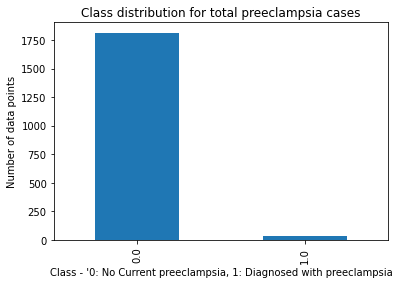

In [13]:
#replace all Nan
protect.replace(9999,np.NaN, inplace = True)
# Class distribution for new variable - total_preeclampsia
pd.value_counts(protect['total_preeclampsia']).plot.bar()
plt.title("Class distribution for total preeclampsia cases")
plt.xlabel("Class - '0: No Current preeclampsia, 1: Diagnosed with preeclampsia")
plt.ylabel("Number of data points")
protect['total_preeclampsia'].value_counts()


In [14]:
#check new data
protect.head()
len(protect)

1859

Data pre-processing and feature selection for the dataset including the new target variable

In [15]:
protect_new = protect.dropna(axis=1, thresh= 0.04 * len(protect),inplace=False)
protect.info()
protect_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859 entries, 0 to 1858
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SYS_LOC_CODE        1859 non-null   int64  
 1   obdiffcard          2 non-null      float64
 2   obdiffhbp           2 non-null      float64
 3   obdiffkidney        2 non-null      float64
 4   obdiffliver         2 non-null      float64
 5   RACE__1             1859 non-null   int64  
 6   RACE__2             1859 non-null   int64  
 7   RACE__3             1859 non-null   int64  
 8   RACE__4             1859 non-null   int64  
 9   RACE__5             1859 non-null   int64  
 10  RACE__6             1859 non-null   int64  
 11  RACE__97            1859 non-null   int64  
 12  RACE__888           1859 non-null   int64  
 13  RACE__999           1859 non-null   int64  
 14  race97              16 non-null     object 
 15  hisp                1731 non-null   float64
 16  smkeve

In [16]:
df = protect_new

In [17]:
df = df.drop('SYS_LOC_CODE', axis=1)

In [18]:
df = df.drop(['RACE__999','RACE__888'], axis =1)

In [19]:
df = df.drop(['pppreeclampsia', 'currpreeclmp','tvcurrpreeclmp'], axis=1)


In [20]:
df.head()

,RACE__1,RACE__2,RACE__3,RACE__4,RACE__5,RACE__6,RACE__97,hisp,smkever,alcdays,marijuse,druguse,fvcurrht_foot,fvcurrht_inch,wtprepreg,prembirthnum,pregnum,prevpreeclmp,preveclmp,curreclmp,currhd,currgd,prevhyp,preghyp_durante,prevdiab,pregdiab_durante,preglup_durante,prevlup,tvcurreclmp,tvcurrgd,ivf,MULTIFETUS,pptypelabor,ppinduct,vitd,cal,total_preeclampsia
0,1,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,85.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,0.0,0.0,0.0
1,1,1,0,0,0,0,1,1.0,0.0,NaN,0.0,0.0,5.0,5.0,155.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,0.0,0.0,0.0
2,0,0,1,0,0,0,0,1.0,1.0,1.0,0.0,0.0,5.0,3.0,200.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,1.0,NaN,NaN,NaN,0.0
3,1,0,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0,5.0,2.0,152.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,0.0,0.0,0.0
4,1,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,5.0,5.0,130.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,0.0,0.0,0.0


Impute missing data with the most frequently occuring points using sklearn categorical imputer

In [21]:
from sklearn_pandas import CategoricalImputer
imputer = CategoricalImputer()

In [22]:
df['marijuse'] = imputer.fit_transform(df['marijuse'])
df['hisp'] = imputer.fit_transform(df['hisp'])
df['smkever'] = imputer.fit_transform(df['smkever'])
df['alcdays'] = imputer.fit_transform(df['alcdays'])
df['druguse'] = imputer.fit_transform(df['druguse'])

In [23]:
# variables related to mother's height are not categorical, hence imputing missing values in this column by mean
df['fvcurrht_foot'] = df['fvcurrht_foot'].fillna(df['fvcurrht_foot'].mean())
df['fvcurrht_inch'] = df['fvcurrht_inch'].fillna(df['fvcurrht_inch'].mean())

In [24]:
# combining height_foot and height_inches into a single column
df['fvcurrht_inch'] = (df['fvcurrht_inch']-df['fvcurrht_inch'].min())/(df['fvcurrht_inch'].max()-df['fvcurrht_inch'].min())
df['fvcurrht'] = df['fvcurrht_foot'] + df['fvcurrht_inch']

In [25]:
df = df.drop(['fvcurrht_foot','fvcurrht_inch'], axis=1)

In [26]:
df['wtprepreg'] = df['wtprepreg'].fillna(df['wtprepreg'].mean())

In [27]:
df['prembirthnum'] = imputer.fit_transform(df['prembirthnum'])
df['pregnum'] = imputer.fit_transform(df['pregnum'])
df['prevpreeclmp'] = imputer.fit_transform(df['prevpreeclmp'])
df['preveclmp'] = imputer.fit_transform(df['preveclmp'])
df['curreclmp'] = imputer.fit_transform(df['curreclmp'])
df['currhd'] = imputer.fit_transform(df['currhd'])
df['currgd'] = imputer.fit_transform(df['currgd'])
df['prevhyp'] = imputer.fit_transform(df['prevhyp'])
df['preghyp_durante'] = imputer.fit_transform(df['preghyp_durante'])
df['prevdiab']	= imputer.fit_transform(df['prevdiab'])
df['pregdiab_durante']	= imputer.fit_transform(df['pregdiab_durante'])
df['preglup_durante']	= imputer.fit_transform(df['preglup_durante'])
df['prevlup'] = imputer.fit_transform(df['prevlup'])
df['tvcurreclmp']	= imputer.fit_transform(df['tvcurreclmp'])
df['tvcurrgd'] = imputer.fit_transform(df['tvcurrgd'])
df['ivf'] = imputer.fit_transform(df['ivf'])
df['MULTIFETUS'] = imputer.fit_transform(df['MULTIFETUS'])
df['vitd'] = imputer.fit_transform(df['vitd'])
df['cal'] = imputer.fit_transform(df['cal'])
df['pptypelabor'] = imputer.fit_transform(df['pptypelabor'])
df['ppinduct'] =  imputer.fit_transform(df['ppinduct'])
df['total_preeclampsia'] = imputer.fit_transform(df['total_preeclampsia'])

In [28]:
df['total_preeclampsia'].unique()

array([0., 1.])

In [29]:
df.columns

Index(['RACE__1', 'RACE__2', 'RACE__3', 'RACE__4', 'RACE__5', 'RACE__6',
       'RACE__97', 'hisp', 'smkever', 'alcdays', 'marijuse', 'druguse',
       'wtprepreg', 'prembirthnum', 'pregnum', 'prevpreeclmp', 'preveclmp',
       'curreclmp', 'currhd', 'currgd', 'prevhyp', 'preghyp_durante',
       'prevdiab', 'pregdiab_durante', 'preglup_durante', 'prevlup',
       'tvcurreclmp', 'tvcurrgd', 'ivf', 'MULTIFETUS', 'pptypelabor',
       'ppinduct', 'vitd', 'cal', 'total_preeclampsia', 'fvcurrht'],
      dtype='object')

In [30]:
for i in df.columns:
  if(df[i].isnull().values.any()):
    print(i)

Splitting the data into test and train sets 

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state = 20)

In [32]:
train_x = train_df[['RACE__1', 'RACE__2', 'RACE__3', 'RACE__4', 'RACE__5', 'RACE__6',
       'RACE__97', 'hisp', 'smkever', 'alcdays', 'marijuse', 'druguse',
       'wtprepreg', 'prembirthnum', 'pregnum', 'prevpreeclmp', 'preveclmp',
        'curreclmp', 'currhd', 'currgd', 'prevhyp',
       'preghyp_durante', 'prevdiab', 'pregdiab_durante', 'preglup_durante',
       'prevlup', 'tvcurreclmp', 'tvcurrgd', 'ivf',
       'MULTIFETUS', 'vitd', 'cal', 'fvcurrht','ppinduct','pptypelabor']]

train_y = train_df[['total_preeclampsia']]

In [33]:
test_x = test_df[['RACE__1', 'RACE__2', 'RACE__3', 'RACE__4', 'RACE__5', 'RACE__6',
       'RACE__97', 'hisp', 'smkever', 'alcdays', 'marijuse', 'druguse',
       'wtprepreg', 'prembirthnum', 'pregnum', 'prevpreeclmp', 'preveclmp',
        'curreclmp', 'currhd', 'currgd', 'prevhyp',
       'preghyp_durante', 'prevdiab', 'pregdiab_durante', 'preglup_durante',
       'prevlup', 'tvcurreclmp', 'tvcurrgd', 'ivf',
       'MULTIFETUS', 'vitd', 'cal', 'fvcurrht','ppinduct','pptypelabor']]

test_y = test_df[['total_preeclampsia']]

Fitting a Logistic Regression model with L1 penalty for feature selection on imbalanced dataset as baseline

In [34]:
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
log.score(test_x, test_y)

0.9811827956989247

In [36]:
log.coef_.ravel()

array([ 6.13296912e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.34498725e+00,  0.00000000e+00,  0.00000000e+00,
       -2.06624218e-03, -3.82180343e-03,  0.00000000e+00, -2.66730923e-03,
        1.99170139e-02,  0.00000000e+00, -2.10756204e-01,  1.64834742e-04,
       -2.30683807e-03,  0.00000000e+00, -3.44203925e-03, -5.25060542e-03,
       -3.28592498e-03,  1.62805913e+00,  0.00000000e+00, -3.92235196e-03,
        4.38116075e-03, -6.06015399e-03,  0.00000000e+00, -2.87209385e-03,
        0.00000000e+00,  0.00000000e+00, -2.03545661e-03, -1.83758240e-03,
       -1.30810858e+00, -4.77691101e-01,  9.70388531e-01])

In [37]:
colnames = train_x.columns

In [38]:
colnames[[0,5,8,9,11,12,14,15,16,18,19,20,21,22,24,25,26,27,29,33,34]]

Index(['RACE__1', 'RACE__6', 'smkever', 'alcdays', 'druguse', 'wtprepreg',
       'pregnum', 'prevpreeclmp', 'preveclmp', 'currhd', 'currgd', 'prevhyp',
       'preghyp_durante', 'prevdiab', 'preglup_durante', 'prevlup',
       'tvcurreclmp', 'tvcurrgd', 'MULTIFETUS', 'ppinduct', 'pptypelabor'],
      dtype='object')

In [39]:
modified_train_x = train_x[['RACE__1', 'RACE__6', 'smkever', 'alcdays', 'druguse', 'wtprepreg',
       'pregnum', 'prevpreeclmp', 'preveclmp', 'currhd', 'currgd', 'prevhyp',
       'preghyp_durante', 'prevdiab', 'preglup_durante', 'prevlup',
       'tvcurreclmp', 'tvcurrgd', 'MULTIFETUS', 'ppinduct', 'pptypelabor']]
                            
modified_train_y = train_y[['total_preeclampsia']]

modified_test_x = test_x[['RACE__1', 'RACE__6', 'smkever', 'alcdays', 'druguse', 'wtprepreg',
       'pregnum', 'prevpreeclmp', 'preveclmp', 'currhd', 'currgd', 'prevhyp',
       'preghyp_durante', 'prevdiab', 'preglup_durante', 'prevlup',
       'tvcurreclmp', 'tvcurrgd', 'MULTIFETUS', 'ppinduct', 'pptypelabor']]

modified_test_y = test_y[['total_preeclampsia']]

In [40]:
mdl2 = LogisticRegression(penalty='l1', solver='liblinear')
mdl2.fit(modified_train_x, modified_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
mdl2.score(modified_test_x, modified_test_y)

0.978494623655914

Confusion Matrix :
 [[364   3]
 [  5   0]]


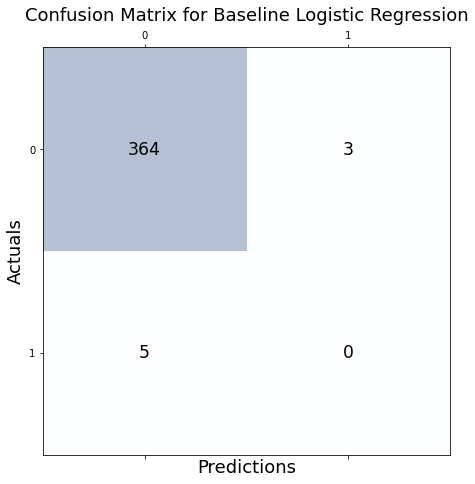

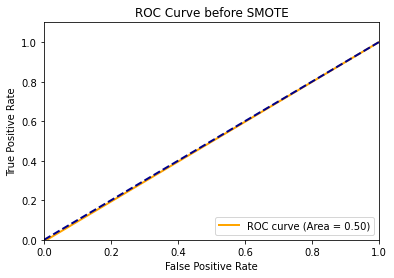

In [43]:
preds_before=mdl2.predict(modified_test_x)
actual_y_before = modified_test_y
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
confusion_mat = confusion_matrix(actual_y_before,preds_before)
print("Confusion Matrix :\n",confusion_mat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Baseline Logistic Regression', fontsize=18)
plt.show()


false_positive_rate, true_positive_rate, _ = roc_curve(actual_y_before,preds_before)
area_under_curve = auc(false_positive_rate,true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='orange',lw=2, label='ROC curve (Area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.title('ROC Curve before SMOTE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend(loc="lower right")
plt.show()



Before SMOTE

In [44]:
modified_train_y.value_counts()

total_preeclampsia
0.0                   1457
1.0                     30
dtype: int64

Text(0, 0.5, 'Number of data points')

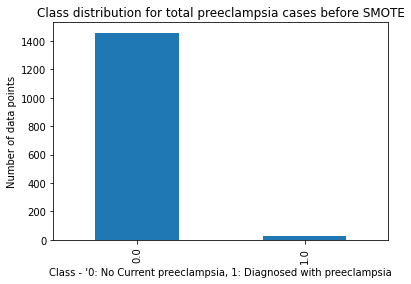

In [45]:
pd.value_counts(modified_train_y['total_preeclampsia']).plot.bar()
plt.title("Class distribution for total preeclampsia cases before SMOTE")
plt.xlabel("Class - '0: No Current preeclampsia, 1: Diagnosed with preeclampsia")
plt.ylabel("Number of data points")


# **Synthetic minority oversampling technique (S.M.O.T.E)**

Synthetic Minority Oversampling Technique was described by Nitesh Chawla et. al. in 2002 works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. The new synthetic data points are extracted from interpolation, so the original dataset still has significance, it interpolates values using a K-nearest neighbouring technique for each minority class instance and generates attribute values for a new data instance. A random data point from minority class is taken and then k- nearest neighbours (usually k =5) for that data point is found and a random neighbour is chosen and a synthetic example for minority class is created at a randomly selected point between these two data points.

In [46]:
from imblearn.over_sampling import SMOTE

sampling = SMOTE(random_state=10,ratio=1)
smote_sampler=sampling.fit_sample(modified_train_x,modified_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

In [47]:
smote_sampler_x=pd.DataFrame(smote_sampler[0],columns=modified_train_x.columns)
smote_sampler_y=pd.DataFrame(smote_sampler[1],columns=modified_train_y.columns)
smote_sampler_total = pd.concat([smote_sampler_x,smote_sampler_y],axis=1)

**After SMOTE -- Class imbalance issue resolved**

In [48]:
print("After smote balancing\n 1.0 represents positive class and 0.0 represents negative class\n")
smote_sampler_total['total_preeclampsia'].value_counts()

After smote balancing
 1.0 represents positive class and 0.0 represents negative class



1.0    1457
0.0    1457
Name: total_preeclampsia, dtype: int64

Text(0, 0.5, 'Number of data points')

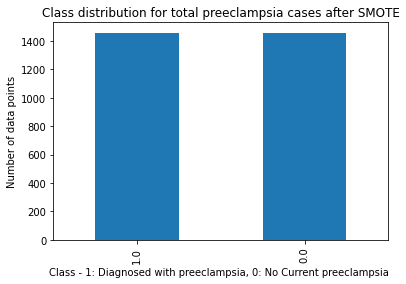

In [49]:
pd.value_counts(smote_sampler_total['total_preeclampsia']).plot.bar()
plt.title("Class distribution for total preeclampsia cases after SMOTE")
plt.xlabel("Class - 1: Diagnosed with preeclampsia, 0: No Current preeclampsia ")
plt.ylabel("Number of data points")

In [50]:
mdl_post_smote = LogisticRegression(penalty='l1', solver='liblinear', C = 10)
mdl_post_smote.fit(smote_sampler_x, smote_sampler_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
mdl_post_smote.score(modified_test_x, modified_test_y)

0.793010752688172

Confusion Matrix :
 [[292  75]
 [  2   3]]


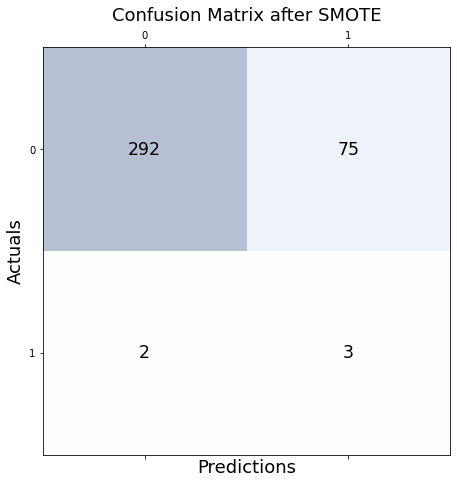

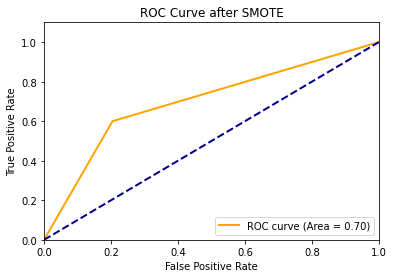

0.07228915662650603


In [52]:
preds=mdl_post_smote.predict(modified_test_x)
actual_y = modified_test_y

confusion_mat = confusion_matrix(actual_y,preds)
print("Confusion Matrix :\n",confusion_mat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix after SMOTE', fontsize=18)
plt.show()

false_positive_rate, true_positive_rate, _ = roc_curve(actual_y,preds)
area_under_curve = auc(false_positive_rate,true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='orange',lw=2, label='ROC curve (Area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.title('ROC Curve after SMOTE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import f1_score
f1_score = f1_score(actual_y,preds)
print(f1_score)

Model performance boosts up after resolving class imbalance in the dataset. AUC score increases from 0.5 to 0.80 which is the best way to compare and judge the performance of the classifiers.

Hence SMOTE resolves class imbalance issues which consequently improves the performance of the classifier.

# Other variants of SMOTE

# **SVM SMOTE**
Another extension to SMOTE involves selecting those instances of minority class that are misclassified such as with KNN model and then oversample just those instances to provide more resolution only where required. These points are usually the ones near the edge of the decision boundary. And in addition to just creating the synthetic points along the borderline of two classes this variant of SMOTE also uses SVM algorithm instead of KNN, which is why it is called Borderline-SVM SMOTE.


In [53]:
from imblearn.over_sampling import SVMSMOTE

sampling = SVMSMOTE(random_state=10)
smote_sampler=sampling.fit_sample(modified_train_x,modified_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

In [54]:
smote_sampler_x=pd.DataFrame(smote_sampler[0],columns=modified_train_x.columns)
smote_sampler_y=pd.DataFrame(smote_sampler[1],columns=modified_train_y.columns)
smote_sampler_total = pd.concat([smote_sampler_x,smote_sampler_y],axis=1)

In [55]:
print("After smote balancing\n 1.0 represents positive class and 0.0 represents negative class\n")
smote_sampler_total['total_preeclampsia'].value_counts()

After smote balancing
 1.0 represents positive class and 0.0 represents negative class



0.0    1457
1.0     807
Name: total_preeclampsia, dtype: int64

Text(0, 0.5, 'Number of data points')

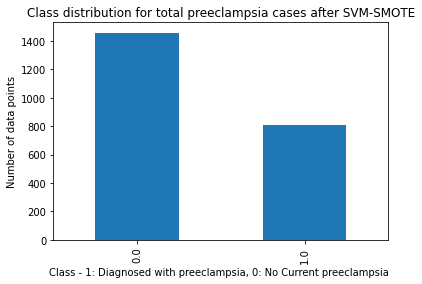

In [56]:
pd.value_counts(smote_sampler_total['total_preeclampsia']).plot.bar()
plt.title("Class distribution for total preeclampsia cases after SVM-SMOTE")
plt.xlabel("Class - 1: Diagnosed with preeclampsia, 0: No Current preeclampsia ")
plt.ylabel("Number of data points")

In [57]:
mdl_post_smote = LogisticRegression(penalty='l1', solver='liblinear', C = 10)
mdl_post_smote.fit(smote_sampler_x, smote_sampler_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
mdl_post_smote.score(modified_test_x, modified_test_y)

0.9193548387096774

Confusion Matrix :
 [[340  27]
 [  3   2]]


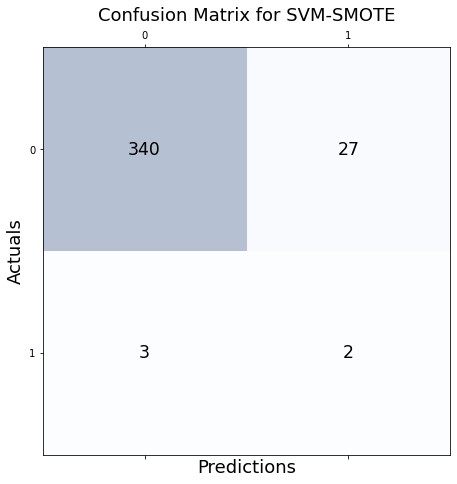

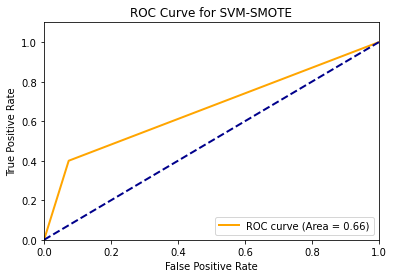

0.1176470588235294


In [59]:
preds=mdl_post_smote.predict(modified_test_x)
actual_y = modified_test_y

confusion_mat = confusion_matrix(actual_y,preds)
print("Confusion Matrix :\n",confusion_mat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for SVM-SMOTE', fontsize=18)
plt.show()

false_positive_rate, true_positive_rate, _ = roc_curve(actual_y,preds)
area_under_curve = auc(false_positive_rate,true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='orange',lw=2, label='ROC curve (Area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.title('ROC Curve for SVM-SMOTE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import f1_score
f1_score = f1_score(actual_y,preds)
print(f1_score)

# ADASYN

Adaptive Synthetic Sampling (ADASYN) is a modification to SMOTE that was developed to overcome the disadvantage of sparsity in vanilla SMOTE. ADASYN’s approach involves generating synthetic samples inversely proportional to the density of the minority class data points, i.e. it generates more synthetic points in regions of feature space where the density of the minority class is low and fewer points where the density is high. The key idea behind ADASYN algorithm is that it uses a density distribution as a criterion to automatically decide the number of synthetic samples that needs to be generated for each minority sample. It adaptively generates minority samples hence the name Adaptive Synthetic Sampling.

In [60]:
from imblearn.over_sampling import ADASYN

sampling = ADASYN(random_state=10)
smote_sampler=sampling.fit_sample(modified_train_x,modified_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [61]:
smote_sampler_x=pd.DataFrame(smote_sampler[0],columns=modified_train_x.columns)
smote_sampler_y=pd.DataFrame(smote_sampler[1],columns=modified_train_y.columns)
smote_sampler_total = pd.concat([smote_sampler_x,smote_sampler_y],axis=1)

In [62]:
print("After smote balancing\n 1.0 represents positive class and 0.0 represents negative class\n")
smote_sampler_total['total_preeclampsia'].value_counts()

After smote balancing
 1.0 represents positive class and 0.0 represents negative class



1.0    1460
0.0    1457
Name: total_preeclampsia, dtype: int64

Text(0, 0.5, 'Number of data points')

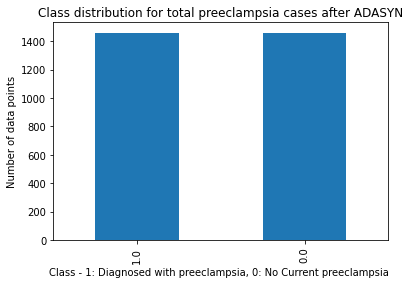

In [63]:
pd.value_counts(smote_sampler_total['total_preeclampsia']).plot.bar()
plt.title("Class distribution for total preeclampsia cases after ADASYN")
plt.xlabel("Class - 1: Diagnosed with preeclampsia, 0: No Current preeclampsia ")
plt.ylabel("Number of data points")

In [64]:
mdl_post_smote = LogisticRegression(penalty='l1', solver='liblinear', C = 10)
mdl_post_smote.fit(smote_sampler_x, smote_sampler_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
mdl_post_smote.score(modified_test_x, modified_test_y)

0.7876344086021505

Confusion Matrix :
 [[290  77]
 [  2   3]]


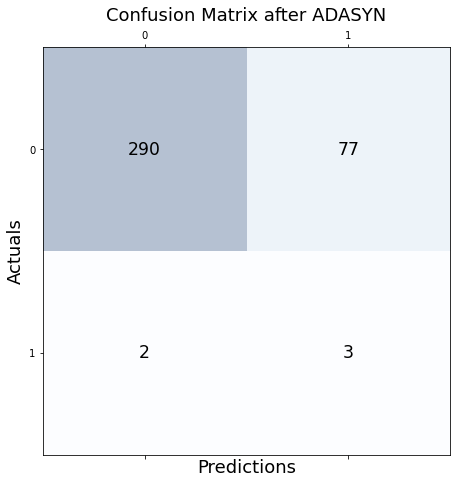

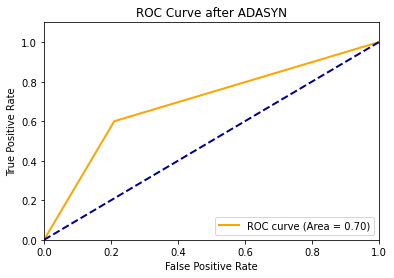

0.07058823529411765


In [66]:
preds=mdl_post_smote.predict(modified_test_x)
actual_y = modified_test_y

confusion_mat = confusion_matrix(actual_y,preds)
print("Confusion Matrix :\n",confusion_mat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix after ADASYN', fontsize=18)
plt.show()

false_positive_rate, true_positive_rate, _ = roc_curve(actual_y,preds)
area_under_curve = auc(false_positive_rate,true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='orange',lw=2, label='ROC curve (Area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.title('ROC Curve after ADASYN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import f1_score
f1_score = f1_score(actual_y,preds)
print(f1_score)

******** End of Code *************

For later reference if needed ..

In [67]:
#pregnum - categorical
#prevpreeclmp - categorical
#preveclmp - categorical
#currpreeclmp - categorical
#curreclmp - categorical
#currhd - categorical
#currgd - categorical
#prevhyp - categorical
#preghyp_durante - categorical
#prevdiab	- categorical
#pregdiab_durante	- categorical
#preglup_durante	- categorical
#prevlup - categorical
#tvcurrpreeclmp	- categorical
#tvcurreclmp	- categorical
#tvcurrgd - categorical
#ivf - categorical
#MULTIFETUS - categorical
#vitd - categorical
#cal - categorical
#total_preeclampsia - categorical